In [1]:
import torch.nn.functional as F
from utilities3 import *
from timeit import default_timer

import numpy as np
import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torchinfo import summary
import sys
import netCDF4 as nc
from data_loader_SSH import load_test_data, load_test_data_DTAS
from data_loader_SSH import load_train_data, load_train_data_DTAS
from count_trainable_params import count_parameters
import hdf5storage

2.0.1+cu117
2.0.1+cu117


In [2]:
import matplotlib.pyplot as plt
import pandas as pd


In [3]:
datastore_filepath = '/data/NASA_DTAS_datastore/'
filename_dict = {
    'u10' : 'U10_large_domain/U10deg_025',
    'v10' : 'V10_large_domain/V10deg_025',
    't2m' : 'T2m_large_domain/T2mdeg_025',
    'mslhf' : 'MSLHF_large_domain/MSLHFdeg_025',
    'msshf' : 'MSSHF_large_domain/MSSHFdeg_025'
}

def get_testdata(yr, vlist, lead):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_test_data_DTAS(DS, lead, v)
        else:
            input_torch, label_torch, _ = load_test_data_DTAS(DS, lead, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

def get_traindata(yr, vlist, lead, trainN):
    """
    high-level wrapper to extract input/label data in torch format from nc file for multiple variables
    --------------------------
    arg: year, list of variables to extract, lead no. of timestep
    
    """
    input_array_torch = torch.zeros((2,2,2,2))
    label_array_torch = torch.zeros((2,2,2,2))
    grid_size = 0

    for i,v in enumerate(vlist):
        # print("dMsg:", i, v)
        DS = nc.Dataset(datastore_filepath + filename_dict[v] + str(yr) + '.nc')
        if i == 0:
            input_array_torch, label_array_torch, grid_size  = load_train_data_DTAS(DS, lead, trainN, v)
        else:
            input_torch, label_torch, _ = load_train_data_DTAS(DS, lead, trainN, v)
            input_array_torch = torch.concatenate((input_array_torch, input_torch), axis=1)
            label_array_torch = torch.concatenate((label_array_torch, label_torch), axis=1)
            
    return input_array_torch, label_array_torch, grid_size

################################################################
# fourier layer
################################################################

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x=64, y=64, c=12)
        output: the solution of the next timestep
        output shape: (batchsize, x=64, y=64, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 8 # pad the domain if input is non-periodic

        self.p = nn.Linear(4, self.width) # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm = nn.InstanceNorm2d(self.width)
        self.q = MLP(self.width, 1, self.width * 4) # output channel is 1: u(x, y)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
        # x = F.pad(x, [0,self.padding, 0,self.padding]) # pad the domain if input is non-periodic

        x1 = self.norm(self.conv0(self.norm(x)))
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv1(self.norm(x)))
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv2(self.norm(x)))
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.norm(self.conv3(self.norm(x)))
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

        # x = x[..., :-self.padding, :-self.padding] # pad the domain if input is non-periodic
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)


def regular_loss(output, target):

 loss = torch.mean((output-target)**2)
 return loss

def ocean_loss(output, target, ocean_grid):

 loss = (torch.sum((output-target)**2))/ocean_grid
 return loss

def spectral_loss(output, target,wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid

 # out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
 # target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)

 out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=1)),dim=2)
 target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=1)),dim=2)


 # loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))

 loss = ((1-lamda_reg)*loss1 + lamda_reg**loss2_ydir)

 return loss

def RK4step(net,input_batch):
 output_1 = net(input_batch.cuda())
 output_2= net(input_batch.cuda()+0.5*output_1)
 output_3 = net(input_batch.cuda()+0.5*output_2)
 output_4 = net(input_batch.cuda()+output_3)

 return input_batch.cuda() + (output_1+2*output_2+2*output_3+output_4)/6


def Eulerstep(net,input_batch):
 output_1 = net(input_batch.cuda())
 return input_batch.cuda() + (output_1)


def directstep(net,input_batch):
  output_1 = net(input_batch.cuda())
  return output_1


def PECstep(net,input_batch):
 output_1 = net(input_batch.cuda()) + input_batch.cuda()
 return input_batch.cuda() + 0.5*(net(input_batch.cuda())+net(output_1))

In [4]:
################################################################
# configs
################################################################
path_outputs = '/data/NASA_DTAS_datastore/ML_models/experimental/'

# FF=nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_0252019.nc')
lead = 1
# varlist = ['u10', 'v10']
varlist = ['mslhf', 'msshf']

# lead = 1

# psi_test_input_Tr_torch, psi_test_label_Tr_torch,_  = load_test_data(FF,lead)
psi_test_input_Tr_torch, psi_test_label_Tr_torch,_ = get_testdata(2019, varlist, lead)


# M_test_level1=torch.mean((psi_test_input_Tr_torch.flatten()))
# STD_test_level1=torch.std((psi_test_input_Tr_torch.flatten()))
M_test_level1 = torch.mean(psi_test_input_Tr_torch, (0,2,3))
STD_test_level1 = torch.std(psi_test_input_Tr_torch, (0,2,3))

#M_test_level1=0
#STD_test_level1=1

# psi_test_input_Tr_torch_norm_level1 = ((psi_test_input_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)
# psi_test_label_Tr_torch_norm_level1 = ((psi_test_label_Tr_torch[:,0,None,:,:]-M_test_level1)/STD_test_level1)

# print('mean value',M_test_level1)
# print('std value',STD_test_level1)
psi_test_input_Tr_torch_norm_level1 = torch.zeros_like(psi_test_input_Tr_torch)
psi_test_label_Tr_torch_norm_level1 = torch.zeros_like(psi_test_label_Tr_torch)

for i in range(len(varlist)):
    psi_test_input_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_input_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])
    psi_test_label_Tr_torch_norm_level1[:,i,None,:,:] = ((psi_test_label_Tr_torch[:,i,None,:,:]-M_test_level1[i])/STD_test_level1[i])



In [5]:
psi_test_label_Tr = psi_test_label_Tr_torch.detach().cpu().numpy()
Nlat = np.size(psi_test_label_Tr,2)
Nlon = np.size(psi_test_label_Tr,3)

In [6]:
batch_size = 10 
num_epochs = 40
num_samples = 2

lamda_reg =0.1
wavenum_init=0
wavenum_init_ydir=0



modes = 16
width = 20

batch_size = 40
learning_rate = 0.001
epochs = 40

In [7]:
net = FNO2d(modes, modes, width).cuda()
print(count_params(net))
# net.load_state_dict(torch.load(path_outputs + 'DTAS_BNN_FNO2D_PECstep_MSSHF_MSLHF_ocean_spectral_loss_modes_16_wavenum0lead1.pt'))
net.load_state_dict(torch.load(path_outputs + 'DTAS_BNN_FNO2D_PECstep_U10_V10_ocean_spectral_loss_modes_16_wavenum0lead1.pt'))

print(net)

1645301
FNO2d(
  (p): Linear(in_features=4, out_features=20, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (mlp0): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp1): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp2): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (mlp3): MLP(
    (mlp1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
    (mlp2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (w0): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(20, 20, kernel_size=(1, 1), stride=(1, 1))
  (norm): In

In [8]:
M=100
autoreg_pred = np.zeros([M,len(varlist),Nlat,Nlon])

for k in range(0,M):

  if (k==0):

    out = (PECstep(net,(psi_test_input_Tr_torch_norm_level1[k,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

  else:

    out = (PECstep(net,(torch.from_numpy(autoreg_pred[k-1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).float()).permute(0,2,3,1).cuda()))
    autoreg_pred[k,:,:,:] = (out.permute(0,3,1,2)).detach().cpu().numpy()

In [10]:
autoreg_pred.shape

(100, 2, 65, 121)

In [11]:
import xarray as xr

In [13]:

# open file with xarray 
saildrone_ds = xr.open_dataset(datastore_filepath + 'processed_data_for_training_v3.nc')

In [18]:
saildrone_ds

<xarray.Dataset>
Dimensions:                      (ID: 6725)
Coordinates:
    time                         (ID) datetime64[ns] ...
    lat                          (ID) float64 ...
    lon                          (ID) float64 ...
  * ID                           (ID) int64 1 2 3 4 5 ... 6722 6723 6724 6725
Data variables: (12/13)
    saildrone_number             (ID) int64 ...
    Q_latent_saildrone           (ID) float64 ...
    Q_sensible_saildrone         (ID) float64 ...
    wind_speed_saildrone         (ID) float64 ...
    Tair_2m_saildrone            (ID) float64 ...
    SST_saildrone                (ID) float64 ...
    ...                           ...
    Q_latent_ERA5                (ID) float64 ...
    Q_lw_ERA5                    (ID) float64 ...
    Q_sensible_ERA5              (ID) float64 ...
    Q_sw_ERA5                    (ID) float64 ...
    SST_ERA5                     (ID) float64 ...
    Tair_2m_ERA5                 (ID) float64 ...
Attributes:
    description:  Hourly mean latent and sensible heat fluxes calculated from...
    COARE_url:    https://github.com/NOAA-PSL/COARE-algorithm

In [9]:
def get_lat_lon():
    FF=nc.Dataset('/data/NASA_DTAS_datastore/MSSHF_large_domain/MSSHFdeg_0252019.nc')
    lat_vals = np.asarray(FF['latitude'])
    lon_vals = np.asarray(FF['longitude'])
    
    return lat_vals, lon_vals

In [61]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera

In [62]:
lat_vals, lon_vals = get_lat_lon()

In [63]:
X, Y = np.meshgrid(lon_vals, lat_vals)



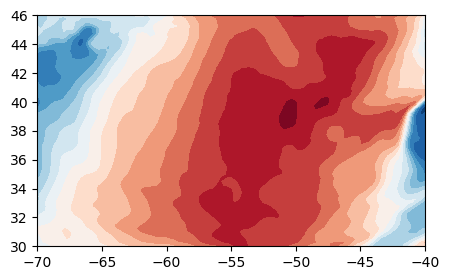

In [64]:
plt.figure(figsize=(5,3))
plt.contourf(X, Y, autoreg_pred[0,1,:,:], 15, cmap='RdBu')
plt.show()

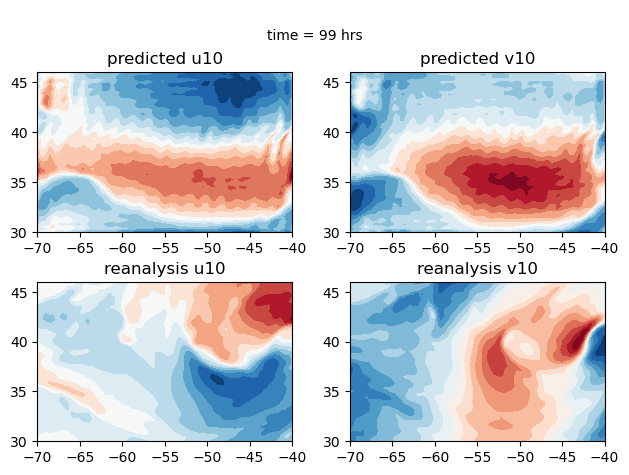

In [65]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

camera = Camera(fig)

for t in range(100):

    axes[0][0].contourf(X, Y, autoreg_pred[t,0,:,:], 15, cmap='RdBu');
    axes[0][1].contourf(X, Y, autoreg_pred[t,1,:,:], 15, cmap='RdBu');

    axes[1][0].contourf(X, Y, psi_test_label_Tr[t,0,:,:], 15, cmap='RdBu');
    axes[1][1].contourf(X, Y, psi_test_label_Tr[t,1,:,:], 15, cmap='RdBu');
    
    axes[0][0].set_title('predicted ' + varlist[0])
    axes[0][1].set_title('predicted ' + varlist[1])
    
    axes[1][0].set_title('reanalysis ' + varlist[0])
    axes[1][1].set_title('reanalysis ' + varlist[1])
    
    fig.suptitle("  ")
    
    axes[0][0].text(0.9, 1.2, 'time = ' + str(t) + ' hrs', transform=axes[0][0].transAxes)
    
    plt.subplots_adjust(top=0.85)
    
    camera.snap()


ani2 = camera.animate()
HTML(ani2.to_html5_video())

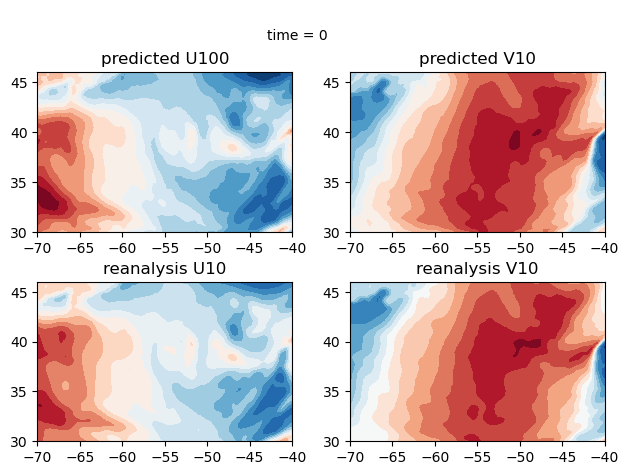

In [43]:
fig, axes = plt.subplots(2,2)
fig.tight_layout(h_pad=2)

# camera = Camera(fig)

for t in range(1):

    axes[0][0].contourf(X, Y, autoreg_pred[t,0,:,:], 15, cmap='RdBu');
    axes[0][1].contourf(X, Y, autoreg_pred[t,1,:,:], 15, cmap='RdBu');

    axes[1][0].contourf(X, Y, psi_test_label_Tr[t,0,:,:], 15, cmap='RdBu');
    axes[1][1].contourf(X, Y, psi_test_label_Tr[t,1,:,:], 15, cmap='RdBu');
    
    axes[0][0].set_title('predicted U10' + str(t))
    axes[0][1].set_title('predicted V10')
    
    axes[1][0].set_title('reanalysis U10')
    axes[1][1].set_title('reanalysis V10')
    
    fig.suptitle("  ")
    
    axes[0][0].text(0.9, 1.2, 'time = ' + str(t), transform=axes[0][0].transAxes)
    
    plt.subplots_adjust(top=0.85)
    
    # camera.snap()


# ani2 = camera.animate()
# HTML(ani2.to_html5_video())

#### Test spectral loss for multivariaye cases

In [112]:
def spectral_loss_mv(output, target,wavenum_init,wavenum_init_ydir,lamda_reg,ocean_grid):

 loss1 = torch.sum((output-target)**2)/ocean_grid
 channel_len = output.shape[-1]

 # out_fft = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,0],dim=2)),dim=1)
 # target_fft = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,0],dim=2)),dim=1)
 
#  out_fft_ydir_list = []
#  target_fft_ydir_list = []
 loss2_ydir_list = []
 
 for v in range(channel_len):
    out_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(output[:,:,:,v],dim=1)),dim=2)
    target_fft_ydir = torch.mean(torch.abs(torch.fft.rfft(target[:,:,:,v],dim=1)),dim=2)
    
    loss2_ydir = torch.mean(torch.abs(out_fft_ydir[:,wavenum_init_ydir:]-target_fft_ydir[:,wavenum_init_ydir:]))
    
    # out_fft_ydir_list.append(out_fft_ydir)
    # target_fft_ydir_list.append(target_fft_ydir)
    loss2_ydir_list.append(loss2_ydir)
    
 loss2_ydir_all_channel = torch.mean(torch.FloatTensor(loss2_ydir_list))
#  print(output.shape, out_fft_ydir.shape) 
 
#  print(target.shape, target_fft_ydir.shape)


 # loss2 = torch.mean(torch.abs(out_fft[:,wavenum_init:]-target_fft[:,wavenum_init:]))
 

 loss = ((1-lamda_reg)*loss1 + lamda_reg**loss2_ydir_all_channel)

 return loss

In [95]:
wavenum_init_ydir

0

In [110]:
output_val = PECstep(net,(psi_test_input_Tr_torch_norm_level1[0:1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1))


In [69]:
output_val.shape

torch.Size([1, 65, 121, 2])

In [78]:
ocean_grid = psi_test_label_Tr.shape[2] * psi_test_label_Tr.shape[3] 

In [79]:
ocean_grid

7865

In [113]:
val_loss = spectral_loss_mv(output_val, (psi_test_label_Tr_torch_norm_level1[0:1,:,0:Nlat,0:Nlon].reshape([1,len(varlist),Nlat,Nlon])).permute(0,2,3,1).cuda(),wavenum_init,wavenum_init_ydir,lamda_reg,(torch.tensor(ocean_grid)).cuda())

In [114]:
val_loss

tensor(0.6583, device='cuda:0', grad_fn=<AddBackward0>)

In [102]:
out_fft = out_fft.detach().cpu().numpy()
target_fft = target_fft.detach().cpu().numpy()

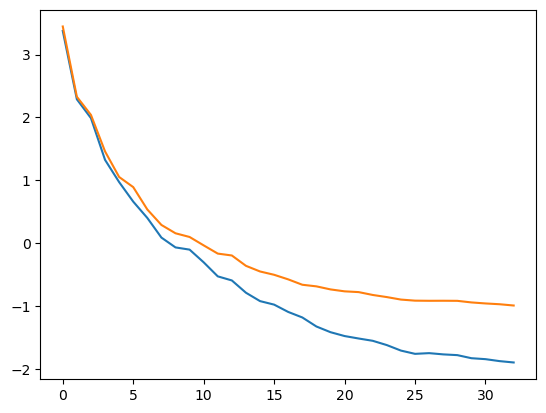

In [108]:
plt.plot(np.log(out_fft[0]))
plt.plot(np.log(target_fft[0]))